## Mercado Libre Tech Challenge Part 4: Time Series Forecasting

### Objetive: build a model to predict daily sales 21 days in the future using historical sales data.

### Imports & Utils

In [10]:
import pandas as pd
import numpy as np
from IPython.display import display
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import optuna
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from enum import Enum
from sklearn.metrics import mean_squared_log_error, r2_score
import pickle


TIME_COLUMNS = [
        "year",
        "month",
        "week_of_year",
        "day_of_week",
        "day_of_month",
        "day_of_year"
    ]

TARGET = "daily_sales"

BACKWARD_WINDOW_SIZE = 30  # Sales in this number of past days will be used as model feature.
FORWARD_WINDOW_SIZE = 21 # Sales will be predicted for this number of days in the future.


class ModelFeatures(list, Enum):
    RAW_TIME = [TARGET] + TIME_COLUMNS
    NORMALIZED_TIME = [TARGET] + [f"{x}_norm" for x in TIME_COLUMNS]
    CYCLIC_TIME = [TARGET] + [f"{x}_sin" for x in TIME_COLUMNS] + [f"{x}_cos" for x in TIME_COLUMNS]
    

def add_cyclic_time(df: pd.DataFrame, time_column: str) -> pd.DataFrame:
    """Adds cyclic encoding of time features to dataset

    Args:
        df (pd.DataFrame): dataset with time column to encode
        time_column (str): time column to encode

    Returns:
        pd.DataFrame: dataset with time encoded columns added.
    """

    time_max = df[time_column].max()
    df[f"{time_column}_sin"] = df[time_column].transform(
        lambda x: np.sin((x - 1) * 2 * np.pi / time_max).astype(np.float64)
        )
    df[f"{time_column}_cos"] = df[time_column].transform(
        lambda x: np.cos((x - 1) * 2 * np.pi / time_max).astype(np.float64)
        )
    
    return df


def add_time_features(df: pd.DataFrame, time_normalize: bool, time_cyclic: bool) -> pd.DataFrame:
    """Adds different time representations to dataset.

    Args:
        df (pd.DataFrame): dataset with time column to use as base for adding time representations
        time_normalize (bool): whether to normalize time representations
        time_cyclic (bool): whether to add cyclic time encoding

    Returns:
        pd.DataFrame: dataset with added time representations
    """
    
    df = pd.concat([df, df["DATE"].dt.isocalendar()],axis=1)
    df.rename(columns={"week": "week_of_year", "day": "day_of_week"}, inplace=True)
    
    df["day_of_month"] = df["DATE"].dt.day
    df["day_of_year"] = df["DATE"].dt.day_of_year
    df["month"] = df["DATE"].dt.month

    for time_col in TIME_COLUMNS:
        if time_cyclic:
            df = add_cyclic_time(df, time_column=time_col)
        if time_normalize:
            df[f"{time_col}_norm"] = minmax_scale(df[time_col], feature_range=(-0.5, 0.5))
                
    
    return df


def clean_up(df: pd.DataFrame) -> pd.DataFrame:
    """Drop duplicates and outliers from dataset

    Args:
        df (pd.DataFrame): raw dataset to clean

    Returns:
        pd.DataFrame: clean dataset
    """
    
    # Clean duplicates
    num_dup = df.shape[0] - df.drop_duplicates().shape[0]
    print(f"Number of duplicate rows in dataset: {num_dup}\n")
    
    if num_dup > 0:
        print("Removing duplicates ...")
        print(f"Dataset number of rows before cleaning duplicates: {df.shape[0]}")
        df.drop_duplicates(inplace=True)
        print(f"Dataset number of rows after cleaning duplicates: {df.shape[0]}")
        
    # Drop outliers
    
    return df


def pre_process(df: pd.DataFrame, time_normalize:bool = False, time_cyclic:bool = False) -> pd.DataFrame:
    """ Pre-process a dataset to use in regression model training.

    Args:
        df (pd.DataFrame): dataset to pre-process
        time_normalize (bool, optional): whether to normalize time representations. Defaults to False.
        time_cyclic (bool, optional): whether to add cyclic time encoding. Defaults to False.

    Returns:
        pd.DataFrame: dataset ready for splitting into training/val/test sets and training.
    """

    # Format date column
    # df = df.astype({"DATE": np.datetime64})

    # Rename sales column
    df.rename(columns={"UNITS_SOLD": "daily_sales"}, inplace=True)
    
    # Add time features
    df = add_time_features(df=df, time_normalize=time_normalize, time_cyclic=time_cyclic)
    
    # Sort by date
    df.sort_values("DATE", ascending=True, inplace=True)
        
    return df


def split(df:pd.DataFrame, model_features: ModelFeatures, train_fraction: float = 0.7, val_fraction: float = 0.15) -> tuple[np.ndarray]:
    """Splits dataset into training, validation and test sets

    Args:
        df (pd.DataFrame): pre-processed dataset for splitting.
        model_features (ModelFeatures): features of the regression model.
        train_fraction (float, optional): fraction of the dataset that will be used for training. Defaults to 0.7.
        val_fraction (float, optional): fraction of the dataset that will be used for validation. 
        The remaining of the dataset wil be used for testing. Defaults to 0.15.

    Returns:
        tuple[np.ndarray]: train, validation and test data splits.
    """
    
    df_size = df.shape[0]
    
    train_split_size = np.floor(df_size * train_fraction)
    train_split_size = int(train_split_size - (train_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    val_split_size = np.floor(df_size * val_fraction)
    val_split_size = int(val_split_size - (val_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    test_split_size = df_size - (train_split_size + val_split_size)
    test_split_size = int(test_split_size - (test_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    train_split_idx = train_split_size
    val_split_idx = train_split_idx + val_split_size
    test_split_idx = val_split_idx + test_split_size
    
    train_split = df[model_features].iloc[0:train_split_idx, :].values.astype("float32")
    val_split = df[model_features].iloc[train_split_idx:val_split_idx, :].values.astype("float32")
    test_split = df[model_features].iloc[val_split_idx:test_split_idx, :].values.astype("float32")
    
    print("--- Splits Summary ---")
    print(f"Model features: {model_features.value}")
    print(f"Train set shape: {train_split.shape}")
    print(f"Val set shape: {val_split.shape}")
    print(f"Test set shape: {test_split.shape}\n")
    
    return train_split, val_split, test_split


def format_batch(batch:np.ndarray, use_covariates) -> np.ndarray:
    """Formats data batches for windows-based XGBoost training.

    Args:
        batch (np.ndarray): batch to format
        use_covariates (_type_): whether to use covariates or not

    Returns:
        np.ndarray: formatted batch
    """

    if use_covariates:
        batch_f = np.concatenate((batch[:, 0],batch[-1, 1:]))
    else:
        batch_f = batch[:, 0],batch[-1, 1:]
    
    return batch_f
    
    
def generate_batches(df: pd.DataFrame, use_covariates: bool = True) -> tuple[np.ndarray]:
    """Splits the datasets into batches for windows-based XGBoost training.

    Args:
        df (pd.DataFrame): dataset to partition into batches
        use_covariates (bool, optional): whether to use covariates or not. Defaults to True.

    Returns:
        tuple[np.ndarray]: (model feature batches, target batches)
    """
    
    num_features = df.shape[1]

    end=df.shape[0]
    start=0
    next=0
    x_batches=[]
    y_batches=[]  
    counter=0
    limit=max(BACKWARD_WINDOW_SIZE,FORWARD_WINDOW_SIZE)
    while next+(limit)<end:
        next=start+BACKWARD_WINDOW_SIZE
        x_batches.append(df[start:next,:])
        y_batches.append(df[next:next+FORWARD_WINDOW_SIZE,0])
        start=start+1
    y_batches=np.asarray(y_batches)
    y_batches = y_batches.reshape(-1, FORWARD_WINDOW_SIZE) 
    x_batches=np.asarray(x_batches) 
    x_batches = x_batches.reshape(-1, BACKWARD_WINDOW_SIZE, num_features)
    
    # Formtat X batches
    x_batches_f = []
    for batch in x_batches:
        x_batches_f.append(format_batch(batch=batch, use_covariates=use_covariates))
    x_batches_f = np.asarray(x_batches_f)
    x_batches_f = x_batches_f.reshape(-1, BACKWARD_WINDOW_SIZE + num_features - 1)
    
    print("--- Batches Summary ---")
    print("Input batches (X):")
    print(f"  Number of batches: {x_batches_f.shape[0]}")
    print(f"  Batch size: {x_batches_f.shape[1]}")
    print(f"  X batch composition: target: {BACKWARD_WINDOW_SIZE} | covariates: {num_features - 1}")
    print("Target batches (Y):")
    print(f"  Number of batches: {y_batches.shape[0]}")
    print(f"  Batch size: {y_batches.shape[1]}")
    print(f"  Y batch composition: target: {FORWARD_WINDOW_SIZE}\n")
   
   
    return x_batches_f, y_batches


def objective(trial, X_train, Y_train, X_val, Y_val, general_params):
    """Optuna function for multi-output XGBoost model hyperparamter tunning.

    Args:
        trial (_type_): hyperparam search step
        X_train (_type_): train set features
        Y_train (_type_): train set target
        X_val (_type_): validation set features
        Y_val (_type_): validation set target
        general_params (_type_): general XGBoost parameters

    Returns:
        _type_: _description_
    """
            
    param = general_params | {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "random_state": trial.suggest_categorical("random_state", [123]),
        "max_depth": trial.suggest_categorical("max_depth", [5, 7, 9, 11, 13, 15, 17, 20]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.013, 0.017, 0.02]),
        "subsample": trial.suggest_categorical("subsample", [0.7, 0.8, 0.9, 1.0]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0),
        "gamma": trial.suggest_float("gamma", 1e-4, 1e-2),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.2, 0.4, 0.6, 0.8, 1.0]),
        "colsample_bynode": trial.suggest_categorical("colsample_bynode", [0.2, 0.4, 0.6, 0.8, 1.0]),
        "colsample_bylevel": trial.suggest_categorical("colsample_bylevel", [0.2, 0.4, 0.6, 0.8, 1.0]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        # "tweedie_variance_power": trial.suggest_categorical("tweedie_variance_power", [1.0, 1.1, 1.2, 1.3, 1.4, 1.5]),
        }
    
    regressor = xgb.XGBRegressor(**param)
    
    model = MultiOutputRegressor(regressor)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "rmse")
    
    model.fit(X_train, Y_train)
    
    preds = model.predict(X_val)
    
    rmsle = mean_squared_log_error(Y_val, np.abs(preds))
    
    return rmsle
    

### Load data

In [2]:
data_path = "../data"
data_file_name = "series.csv"
data_raw = pd.read_csv(f"{data_path}/{data_file_name}")

print("Dataset info:")
print(f"{data_raw.info()}\n")

print("Dataset sample:")
display(data_raw.sample(10, random_state=152))

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB
None

Dataset sample:


,CATEGORY,DATE,UNITS_SOLD
136,CATEG-3,2021-05-07,2559
452,CATEG-3,2021-08-14,2085
181,CATEG-1,2021-03-05,77
528,CATEG-2,2021-06-06,42
2477,CATEG-2,2020-12-14,24
1951,CATEG-2,2021-08-23,28
316,CATEG-2,2020-02-17,7
2285,CATEG-3,2020-04-17,861
1383,CATEG-3,2021-01-28,2136
179,CATEG-2,2020-11-06,4


#### Dataset relevant features

##### Sales time series

<AxesSubplot: xlabel='DATE'>

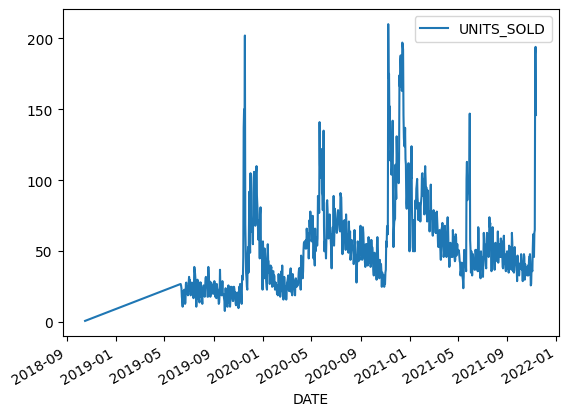

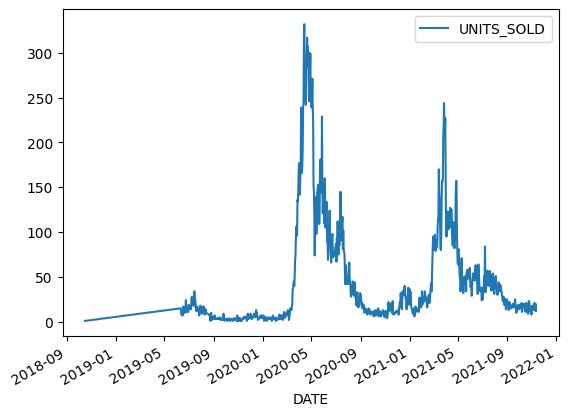

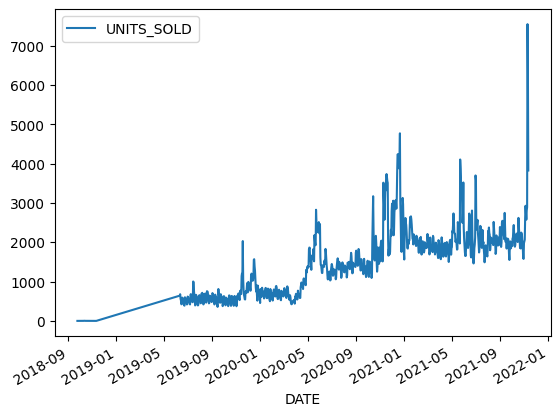

In [3]:
data_raw = data_raw.astype({"DATE": np.datetime64})
data_raw.loc[data_raw["CATEGORY"] == "CATEG-1"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-2"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-3"].plot(x="DATE", y="UNITS_SOLD")

<AxesSubplot: xlabel='DATE'>

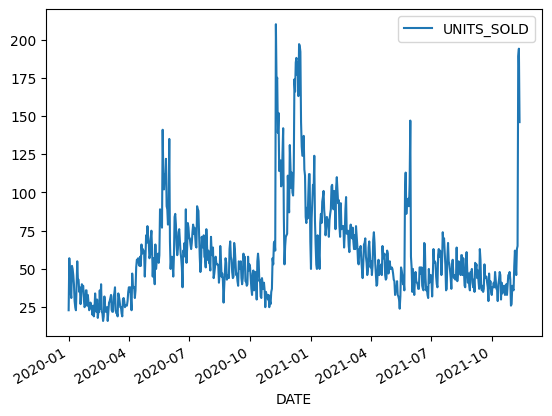

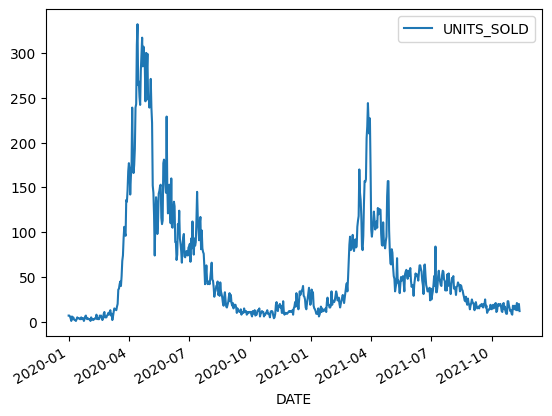

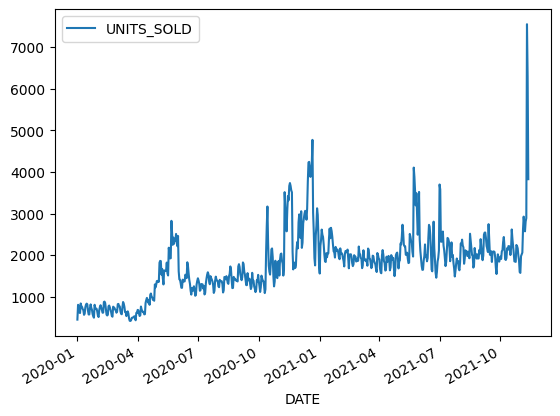

In [4]:
data_raw = data_raw.loc[data_raw["DATE"].dt.year > 2019]

data_raw.loc[data_raw["CATEGORY"] == "CATEG-1"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-2"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-3"].plot(x="DATE", y="UNITS_SOLD")

##### Sales distribution

In [5]:
data_raw[["CATEGORY", "UNITS_SOLD"]].groupby("CATEGORY").describe()

UNITS_SOLD                                                          \
              count         mean         std    min     25%     50%     75%   
CATEGORY                                                                      
CATEG-1       682.0    58.917889   30.794792   16.0    39.0    52.0    68.0   
CATEG-2       682.0    55.476540   63.509664    1.0    13.0    31.0    79.0   
CATEG-3       682.0  1772.445748  775.400137  423.0  1315.5  1827.5  2124.0   

                  
             max  
CATEGORY          
CATEG-1    210.0  
CATEG-2    332.0  
CATEG-3   7551.0

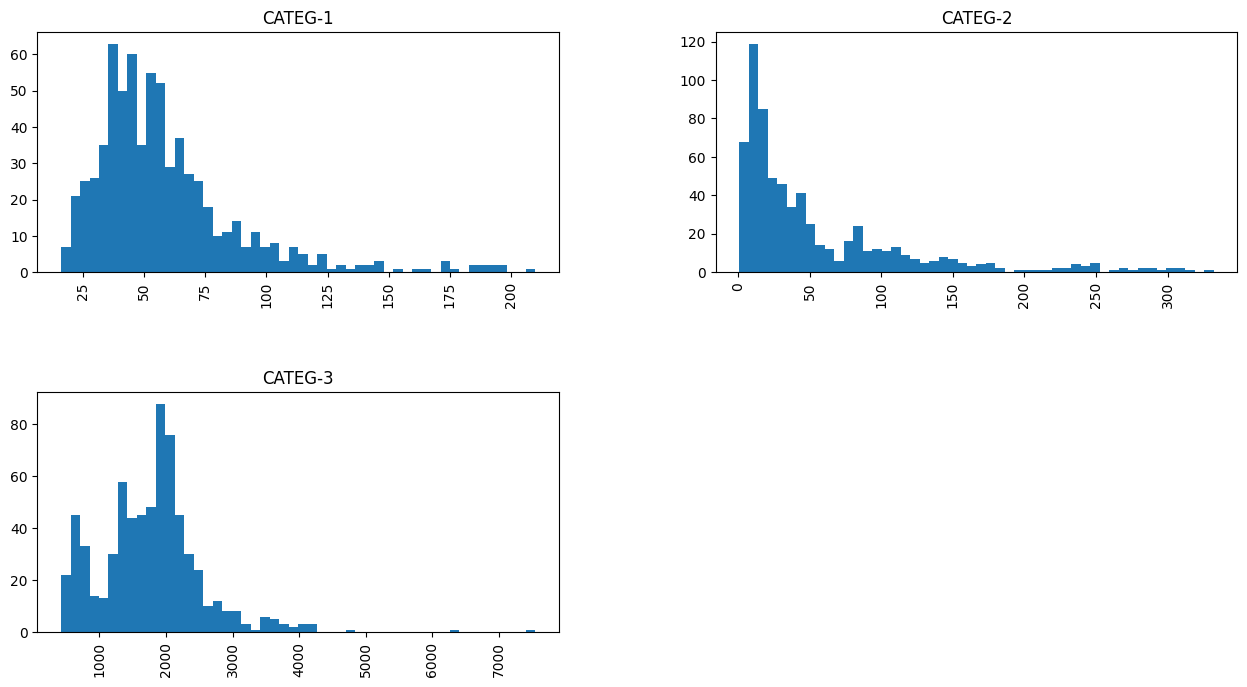

In [6]:
h = data_raw[["CATEGORY", "UNITS_SOLD"]].hist(by="CATEGORY", figsize=(15,8), bins=50)

##### Observations

Although daily sales data is available, for the three categories of products, since Sept/Oct 2018, there is a big jump between that period of 2018 and June 2019. Consequently, only data after June 2019 should be considered.

All three categories have similar number of datapoints. Thus, differences in model quality should not emerge between categories due to data availability.

The three catogories show te following daily sales distributions characteristics:
- **Range of values**: categories 1 and 2 range from 0 to 200-300 sales per day, while categoy 1 ranges from 0 to >4000. Segmenting products in terms or volume sales and training volume-segment specific models is a good idea to improve model quality, avoiding having a single model trying to predict wildly different sales values. An alternative here could be to target encode the categorical varible `CATEGORY` using as target encoding feature the daily sales, however, that adds extra complexity to the model. In the present case, for time reasons, only volume segment specific models will be trained, but it would be desirable to also train a single model using target encoding for comparison.

- **Distribution**: while categories 1 and 2 show a mean peak accompanied by a right tail of different strenght (more important for category 2), category 3 shows two important peaks, one below and the other above 1000 sales. As revealed by the time series, values below 1000 occurred before April/May 2020, while a notable increase is observed after that date. This is an indication of a change in the market for this category, and hints on the need to treat/model the behaviour of category 3 taking that into consideration. In the present work, the focus will be on the data after the increase in sales for this category, to make sure the generated model reflects a state of the market closer to the present.

- **Long right tails**: although sales distributions of categories 1 and 3 show a certain degree of right tails, those are not substantial, which is evidence by the similarity between their means and medians (see table above). However, in the case of category 2 a strong heavy tail is observed, highlighted by the difference between the mean (~55) and the median (~31). In this context, although using a tweedie regression should help improving model quality, it is expected poorer predictions compared to categories 1 and 3. To further improve modelling of category 2, it would be interesting to try to segment the associated products in terms of sales volume and train better specific models. 




### Modelling approach

Herein the following modelling approach will be used to predict daily sales in a future time window of 21 days:
- Three models, one per category will be trained
- Each model will be based on Tweedie regression using the XGBoost method in the Multiple-Output format that allows multiple regressors, one for each day of the future time window (21 regressors). 
- To alleviate the problem of having multiple **independent** regressors, the window-based approach of [Elsayed et al (2021)](https://arxiv.org/pdf/2101.02118.pdf) will be used. In particular, the version including covariates will be employed, as the corresponding data is available in the dataset, and such an approach results in the best option compared with state of the art methods, as described in article.
- The date (in different representations) will be used as covariate in the regression, testing different ways to scale/encode time (raw, normalization, cyclic time).
- The dataset will be splitted by category and into training, validation and test sets. On model per category will be trained, searching for optimal hyperparameters using the Tree-structured Parzen Estimator method (a form of bayesian optimization) on the validation set, and finally retraining the model with the best hyperparameters found, combinig the training adn validation set, and testing on the test set.

### Dataset pre-processing

In [9]:
# Data cleanup and pre-processing
data_clean = clean_up(df=data_raw)
data = pre_process(df=data_clean, time_normalize=True, time_cyclic=True)

# Split by category
training_data = {
    "CATEG-1": {
        "data": data.loc[data["CATEGORY"] == "CATEG-1"],
        "train_set": {"X": None, "Y": None},
        "val_set": {"X": None, "Y": None},
        "test_set": {"X": None, "Y": None},
        "hypersearch_data": None,
        "model": None,
    },
    "CATEG-2": {
        "data": data.loc[data["CATEGORY"] == "CATEG-2"],
        "train_set": {"X": None, "Y": None},
        "val_set": {"X": None, "Y": None},
        "test_set": {"X": None, "Y": None},
        "hypersearch_data": None,
        "model": None,
    },
    "CATEG-3": {
        "data": data.loc[
            (data["CATEGORY"] == "CATEG-3")
            & (data["year"] >= 2020)
            & (data["month"] >= 6)
            ],
        "train_set": {"X": None, "Y": None},
        "val_set": {"X": None, "Y": None},
        "test_set": {"X": None, "Y": None},
        "hypersearch_data": None,
        "model": None,
    }
}

for c in training_data.keys():
    print(f" ----- Generating datasets for category {c} ----- ")
    train_set, val_set, test_set = split(df=training_data[c]["data"], model_features=ModelFeatures.NORMALIZED_TIME, train_fraction=0.7, val_fraction=0.15)
    print("Training set batches:")
    training_data[c]["train_set"]["X"], training_data[c]["train_set"]["Y"]  = generate_batches(df=train_set)
    print("Validation set batches:")
    training_data[c]["val_set"]["X"], training_data[c]["val_set"]["Y"]  = generate_batches(df=val_set)
    print("Test set batches:")
    training_data[c]["test_set"]["X"], training_data[c]["test_set"]["Y"]  = generate_batches(df=test_set)
    

Number of duplicate rows in dataset: 0

 ----- Generating datasets for category CATEG-1 ----- 
--- Splits Summary ---
Model features: ['daily_sales', 'year_norm', 'month_norm', 'week_of_year_norm', 'day_of_week_norm', 'day_of_month_norm', 'day_of_year_norm']
Train set shape: (459, 7)
Val set shape: (102, 7)
Test set shape: (102, 7)

Training set batches:
--- Batches Summary ---
Input batches (X):
  Number of batches: 400
  Batch size: 36
  X batch composition: target: 30 | covariates: 6
Target batches (Y):
  Number of batches: 400
  Batch size: 21
  Y batch composition: target: 21

Validation set batches:
--- Batches Summary ---
Input batches (X):
  Number of batches: 43
  Batch size: 36
  X batch composition: target: 30 | covariates: 6
Target batches (Y):
  Number of batches: 43
  Batch size: 21
  Y batch composition: target: 21

Test set batches:
--- Batches Summary ---
Input batches (X):
  Number of batches: 43
  Batch size: 36
  X batch composition: target: 30 | covariates: 6
Targe

### Model training

In [11]:
for c in training_data.keys():
    print(f"Training model for category {c} ...")
    
    # Hyper-parameter optimization
    general_params = {
        "n_jobs": -1,
        "tree_method":"hist",
        # "objective": "reg:tweedie",
        "objective": "reg:squarederror",
        "booster": "gbtree",
    }

    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(), 
        direction='minimize', 
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        )

    study.optimize( 
        lambda trial: objective(
            trial=trial, 
            X_train=training_data[c]["train_set"]["X"], 
            Y_train=training_data[c]["train_set"]["Y"], 
            X_val=training_data[c]["val_set"]["X"], 
            Y_val=training_data[c]["val_set"]["Y"],
            general_params=general_params),
        n_trials=5, 
        gc_after_trial=True)

    print(f"Best RMSLE: {study.best_trial.value}")
    print(f"Best trial: {study.best_trial.params}")
    
    training_data[c]["hypersearch_data"] = study
    
    best_xgbparams = general_params | study.best_params 
    print(f"Best parameters: {best_xgbparams}")
    
    # Train model using best hyper-parameters
    model = xgb.XGBRegressor(**best_xgbparams)
    multioutput=MultiOutputRegressor(model).fit(
        np.concatenate([
            training_data[c]["train_set"]["X"], 
            training_data[c]["val_set"]["X"]
            ]),
        np.concatenate([
            training_data[c]["train_set"]["Y"], 
            training_data[c]["val_set"]["Y"]
            ])
        )
    training_data[c]["model"] = multioutput
    
    

[I 2022-11-14 01:08:40,681] A new study created in memory with name: no-name-e85774bb-3ef0-4304-a9d1-879e26a9fef1


Training model for category CATEG-1 ...


[I 2022-11-14 01:14:41,848] Trial 0 finished with value: 0.19107939302921295 and parameters: {'n_estimators': 95, 'random_state': 123, 'max_depth': 17, 'learning_rate': 0.017, 'subsample': 1.0, 'reg_alpha': 0.9840818668138176, 'reg_lambda': 7.0103247152959165, 'gamma': 0.008097646622227613, 'colsample_bytree': 0.2, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.4, 'min_child_weight': 175}. Best is trial 0 with value: 0.19107939302921295.
[I 2022-11-14 01:23:58,526] Trial 1 finished with value: 0.1612836867570877 and parameters: {'n_estimators': 147, 'random_state': 123, 'max_depth': 17, 'learning_rate': 0.01, 'subsample': 0.9, 'reg_alpha': 5.351972015989578, 'reg_lambda': 0.6312918083677638, 'gamma': 0.0063273567914310155, 'colsample_bytree': 0.2, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.6, 'min_child_weight': 242}. Best is trial 1 with value: 0.1612836867570877.
[I 2022-11-14 01:33:13,864] Trial 2 finished with value: 0.20864985883235931 and parameters: {'n_estimators': 150, '

Best RMSLE: 0.16104407608509064
Best trial: {'n_estimators': 109, 'random_state': 123, 'max_depth': 11, 'learning_rate': 0.013, 'subsample': 0.9, 'reg_alpha': 7.745037550422058, 'reg_lambda': 3.8326599997195547, 'gamma': 0.0003294426592720447, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 200}
Best parameters: {'n_jobs': -1, 'tree_method': 'hist', 'objective': 'reg:squarederror', 'booster': 'gbtree', 'n_estimators': 109, 'random_state': 123, 'max_depth': 11, 'learning_rate': 0.013, 'subsample': 0.9, 'reg_alpha': 7.745037550422058, 'reg_lambda': 3.8326599997195547, 'gamma': 0.0003294426592720447, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 200}


[I 2022-11-14 01:59:38,377] A new study created in memory with name: no-name-6cd1d640-9132-405a-8b55-09b8f315b435


Training model for category CATEG-2 ...


[I 2022-11-14 02:09:32,964] Trial 0 finished with value: 0.6115597486495972 and parameters: {'n_estimators': 113, 'random_state': 123, 'max_depth': 13, 'learning_rate': 0.02, 'subsample': 0.9, 'reg_alpha': 4.62291231948771, 'reg_lambda': 3.193021200300116, 'gamma': 0.00032215350020014605, 'colsample_bytree': 1.0, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 160}. Best is trial 0 with value: 0.6115597486495972.
[I 2022-11-14 02:21:15,508] Trial 1 finished with value: 0.1264926791191101 and parameters: {'n_estimators': 117, 'random_state': 123, 'max_depth': 13, 'learning_rate': 0.013, 'subsample': 0.8, 'reg_alpha': 3.6994333931490444, 'reg_lambda': 4.596899230014668, 'gamma': 0.00946038717010836, 'colsample_bytree': 0.8, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 63}. Best is trial 1 with value: 0.1264926791191101.
[I 2022-11-14 02:40:51,341] Trial 2 finished with value: 0.24410824477672577 and parameters: {'n_estimators': 131, 'rando

In [15]:
# Store trained models
with open("models/category_1_models.pkl", "wb") as ph: 
    pickle.dump(training_data["CATEG-1"]["model"], ph)
    
with open("models/category_2_models.pkl", "wb") as ph: 
    pickle.dump(training_data["CATEG-2"]["model"], ph)
    
with open("models/category_3_models.pkl", "wb") as ph: 
    pickle.dump(training_data["CATEG-3"]["model"], ph)
    
with open("models/training_data.pkl", "wb") as ph: 
    pickle.dump(training_data, ph)

### Evaluate

In [16]:
for c in training_data.keys():
    print(f"Evaluating model for category {c} ...")
    
    x_batches_test = training_data[c]["test_set"]["X"]
    y_batches_test = training_data[c]["test_set"]["Y"]

    prediction=training_data[c]["model"].predict(x_batches_test)
    RMSE=np.sqrt(np.mean(np.power((prediction - y_batches_test),2)))
    MAE=np.mean(np.abs((prediction - y_batches_test)))
    MAPE=np.mean((np.abs(prediction - y_batches_test) / np.abs(y_batches_test)))
    R2 = r2_score(y_batches_test, prediction)

    print(f"MAE: {MAE}") 
    print(f"MAPE: {MAPE}")   
    print(f"RMSE: {RMSE}")
    
    plt.plot(y_batches_test[50])
    plt.plot(prediction[50])
    plt.show()
    

Evaluating model for category CATEG-1 ...


AttributeError: 'NoneType' object has no attribute 'predict'